# Train Patch Classifier
This notebook loads inputs created in `create_patch_dataset` to train a spatial classifier


In [270]:
import json
import os
import pickle
import sys

import cv2
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

sys.path.append('../')
from scripts.get_s2_data_ee import get_history, get_history_polygon, get_pixel_vectors

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [271]:
# Sentinel 2 band descriptions
band_descriptions = {
    'B1': 'Aerosols, 442nm',
    'B2': 'Blue, 492nm',
    'B3': 'Green, 559nm',
    'B4': 'Red, 665nm',
    'B5': 'Red Edge 1, 704nm',
    'B6': 'Red Edge 2, 739nm',
    'B7': 'Red Edge 3, 779nm',
    'B8': 'NIR, 833nm',
    'B8A': 'Red Edge 4, 864nm',
    'B9': 'Water Vapor, 943nm',
    'B11': 'SWIR 1, 1610nm',
    'B12': 'SWIR 2, 2186nm'
}

In [272]:
def stretch_histogram(array, min_val=0.1, max_val=0.75, gamma=1.2):
    clipped = np.clip(array, min_val, max_val)
    stretched = (clipped - min_val) / (max_val - min_val) ** gamma
    return stretched

## Load Data
Data is generated in the `create_spatial_patches` notebook

In [277]:
OUTPUT_DIR = '../data/sentinel'

rect_width = 0.004

num_positive_months = 12
positive_start_date = '2019-01-01'

num_negative_months = 6
negative_start_date = '2019-03-01'


# Load positive patches
with open(os.path.join(OUTPUT_DIR, f"positive_patches_{rect_width}_toa_{num_positive_months}_{positive_start_date}.pkl"),"rb") as f:
    positive_img = pickle.load(f)
    
# Load negative patches
with open(os.path.join(OUTPUT_DIR, f"negative_patches_{rect_width}_toa_{num_negative_months}_{negative_start_date}.pkl"),"rb") as f:
    negative_img = pickle.load(f)

In [252]:
# Negative site coordinates

with open('../data/bootstrap_negatives.geojson', 'r') as f:
    negative_bootstrap = json.load(f)['features']
neg_bootstrap_coords = [site['geometry']['coordinates'] for site in negative_bootstrap]
neg_bootstrap_names = ['bootstrap_' + str(index) for index in range(len(negative_bootstrap))]
print(len(negative_bootstrap), 'negative sites loaded')

47 negative sites loaded


In [263]:
import pandas as pd
java_bootstrap = pd.read_csv('../data/model_outputs/candidate_sites/v12_java_2D_candidates_0.4_threshold.csv')
del java_bootstrap['Unnamed: 0']
java_bootstrap_coords = [[lon, lat] for lon, lat in zip(java_bootstrap['lon'], java_bootstrap['lat'])]
java_bootstrap_names = ['java_' + str(index) for index in range(len(java_bootstrap))]

In [264]:
java_curated = pd.read_csv('../data/model_outputs/candidate_sites/v12_java_2D_candidates_0.4_threshold_validated.csv')
java_positive_index = java_curated['label'] == 1
java_positive_coords = np.array(java_bootstrap_coords)[java_positive_index]
java_positive_names = np.array(java_bootstrap_names)[java_positive_index]

java_negative_index = java_curated['label'] == 0
java_negative_coords = np.array(java_bootstrap_coords)[java_negative_index]
java_negative_names = np.array(java_bootstrap_names)[java_negative_index]

In [267]:
pd.DataFrame({
    'name': java_positive_names,
    'lon': java_positive_coords[:,0],
    'lat': java_positive_coords[:,1],
    'coords': [[coord[0], coord[1]] for coord in java_positive_coords]
}).to_csv('../data/training_sites/v12_java_validated_positives.csv', index=False)


pd.DataFrame({
    'name': java_negative_names,
    'lon': java_negative_coords[:,0],
    'lat': java_negative_coords[:,1],
    'coords': [[coord[0], coord[1]] for coord in java_negative_coords]
}).to_csv('../data/training_sites/v12_java_validated_negatives.csv', index=False)

## Download Data

In [938]:
# Enter rect width in degrees (0.035 max recommended) and site coordinates
rect_width = 0.004

In [939]:
bali_positive_history = get_history(positive_coords, 
                               positive_names, 
                               rect_width,
                               num_months = 12,
                               start_date = '2019-01-01')

  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [00:49<09:02, 49.30s/it]

 17%|█▋        | 2/12 [01:22<07:24, 44.50s/it]

 25%|██▌       | 3/12 [02:08<06:44, 44.89s/it]

 33%|███▎      | 4/12 [02:44<05:36, 42.12s/it]

 42%|████▏     | 5/12 [03:38<05:21, 45.95s/it]

 50%|█████     | 6/12 [04:21<04:29, 44.84s/it]

 58%|█████▊    | 7/12 [05:28<04:18, 51.73s/it]

 67%|██████▋   | 8/12 [06:23<03:30, 52.70s/it]

 75%|███████▌  | 9/12 [07:01<02:24, 48.09s/it]

 83%|████████▎ | 10/12 [08:25<01:58, 59.05s/it]

 92%|█████████▏| 11/12 [09:07<00:53, 53.82s/it]

100%|██████████| 12/12 [09:48<00:00, 49.05s/it]


In [940]:
bali_negative_history = get_history(neg_bootstrap_coords, 
                               neg_bootstrap_names, 
                               rect_width,
                               num_months = 12,
                               start_date = '2019-01-01')

  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [01:36<17:41, 96.50s/it]

 17%|█▋        | 2/12 [03:58<18:21, 110.17s/it]

 25%|██▌       | 3/12 [05:17<15:06, 100.74s/it]

 33%|███▎      | 4/12 [08:06<16:11, 121.40s/it]

 42%|████▏     | 5/12 [10:42<15:22, 131.77s/it]

 50%|█████     | 6/12 [12:42<12:48, 128.13s/it]

 58%|█████▊    | 7/12 [15:00<10:55, 131.09s/it]

 67%|██████▋   | 8/12 [16:45<08:12, 123.17s/it]

 75%|███████▌  | 9/12 [18:40<06:02, 120.73s/it]

 83%|████████▎ | 10/12 [21:16<04:22, 131.47s/it]

 92%|█████████▏| 11/12 [23:34<02:13, 133.30s/it]

100%|██████████| 12/12 [25:30<00:00, 127.52s/it]


In [946]:
java_positive_history = get_history(java_positive_coords, 
                                    java_positive_names, 
                                    rect_width,
                                    num_months = 12,
                                    start_date = '2019-01-01')

  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [05:55<1:05:14, 355.90s/it]

 17%|█▋        | 2/12 [10:13<54:23, 326.39s/it]  

 25%|██▌       | 3/12 [14:53<46:52, 312.48s/it]

 33%|███▎      | 4/12 [19:26<40:05, 300.66s/it]

 42%|████▏     | 5/12 [25:10<36:35, 313.65s/it]

 50%|█████     | 6/12 [30:21<31:18, 313.01s/it]

 58%|█████▊    | 7/12 [35:58<26:40, 320.02s/it]

 67%|██████▋   | 8/12 [41:10<21:10, 317.72s/it]

 75%|███████▌  | 9/12 [46:49<16:11, 323.97s/it]

 83%|████████▎ | 10/12 [56:44<13:30, 405.46s/it]

 92%|█████████▏| 11/12 [1:10:49<08:57, 537.07s/it]

100%|██████████| 12/12 [1:20:32<00:00, 402.75s/it]


In [947]:
java_negative_history = get_history(java_negative_coords, 
                                    java_negative_names, 
                                    rect_width,
                                    num_months = 12,
                                    start_date = '2019-01-01')

  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [29:32<5:25:02, 1772.97s/it]

 17%|█▋        | 2/12 [1:01:25<5:02:26, 1814.69s/it]

 25%|██▌       | 3/12 [1:31:27<4:31:38, 1810.94s/it]

 33%|███▎      | 4/12 [2:00:36<3:59:00, 1792.51s/it]

 42%|████▏     | 5/12 [2:25:19<3:18:16, 1699.47s/it]

 50%|█████     | 6/12 [2:42:55<2:30:39, 1506.62s/it]

 58%|█████▊    | 7/12 [3:01:25<1:55:37, 1387.43s/it]

 67%|██████▋   | 8/12 [3:18:52<1:25:42, 1285.58s/it]

 75%|███████▌  | 9/12 [3:35:51<1:00:16, 1205.52s/it]

 83%|████████▎ | 10/12 [3:52:46<38:16, 1148.35s/it] 

 92%|█████████▏| 11/12 [4:07:34<17:50, 1070.31s/it]

100%|██████████| 12/12 [4:18:18<00:00, 1291.58s/it]


In [ ]:
def create_img_stack(patch_history):
    img_stack = []
    for date in patch_history:
        for site in patch_history[date]:
            spectral_stack = []
            band_shapes = [np.shape(patch_history[date][site][band])[0] for band in band_descriptions]
            if np.array(band_shapes).all() > 0:
                for band in band_descriptions:
                    spectral_stack.append(patch_history[date][site][band])
                if np.min(spectral_stack) > 0:
                    img_stack.append(np.rollaxis(np.array(spectral_stack), 0, 3))
    
    min_x = np.min([np.shape(img)[0] for img in img_stack])
    min_y = np.min([np.shape(img)[1] for img in img_stack])
    img_stack = [img[:min_x, :min_y, :] for img in img_stack]
    return img_stack

def normalize(x):
    return (np.array(x)) / (3000)

In [951]:
min_dimension

45

In [ ]:
positive_img = create_img_stack(positive_patch_histories)
negative_img = create_img_stack(negative_patch_histories)
print(len(positive_img), 'positive images extracted')
print(len(negative_img), 'negative images extracted')

In [955]:
positive_img = np.concatenate((bali_positive_img, java_positive_img), axis=0)
negative_img = np.concatenate((bali_negative_img, java_negative_img), axis=0)

## Prepare training dataset

In [278]:
x = normalize(np.concatenate((positive_img, negative_img)))
y = np.concatenate((np.ones(len(positive_img)), np.zeros(len(negative_img))))
x, y = shuffle(x, y, random_state=42)

In [279]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)
print("Num Train:\t\t", len(x_train))
print("Num Test:\t\t", len(x_test))
print(f"Percent Negative Train:\t {100 * sum(y_train == 0.0) / len(y_train):.1f}")
print(f"Percent Negative Test:\t {100 * sum(y_test == 0.0) / len(y_test):.1f}")

num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Num Train:		 2250
Num Test:		 251
Percent Negative Train:	 63.2
Percent Negative Test:	 64.5


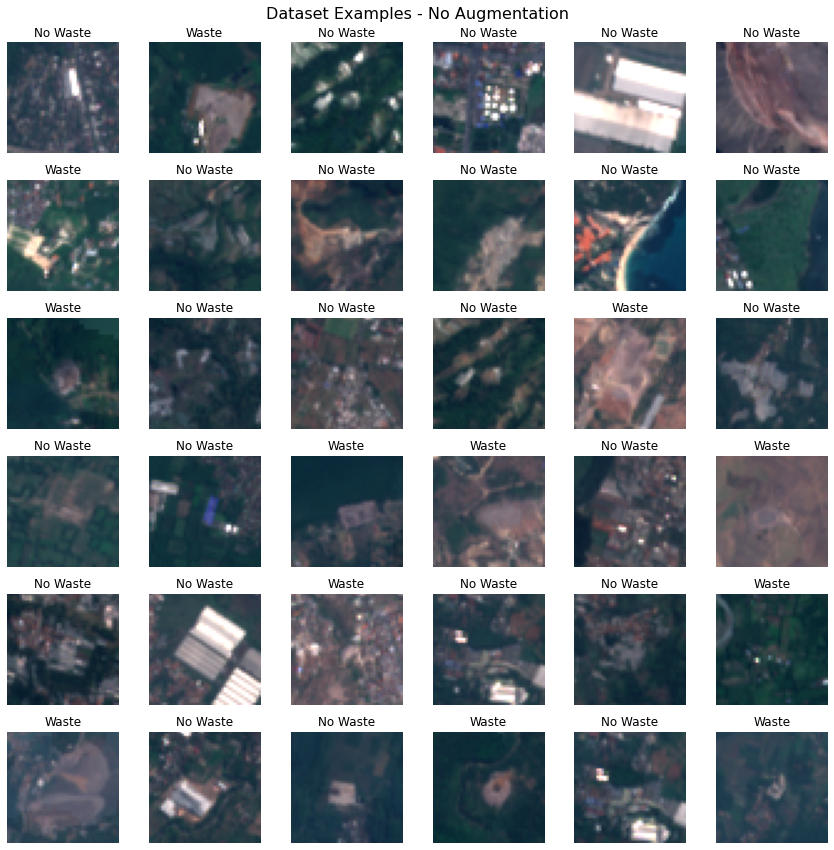

In [281]:
datagen = ImageDataGenerator(
    rotation_range=0
)


plt.figure(figsize=(12,12), facecolor=(1,1,1))
images, labels = datagen.flow(x_train, y_train, batch_size=36).next()
for index, (image, label) in enumerate(zip(images, labels)):

    rgb = np.stack((image[:,:,3],
                    image[:,:,2], 
                    image[:,:,1]), axis=-1)
    rgb_stretch = stretch_histogram(rgb, max_val = 1)
    plt.subplot(6,6,index+1)
    plt.imshow(np.clip(rgb_stretch, 0, 1))
    if label[1] == 1:
        plt.title('Waste')
    else:
        plt.title('No Waste')
    plt.axis('off')
plt.suptitle('Dataset Examples - No Augmentation', size=16)
plt.tight_layout()
plt.show()

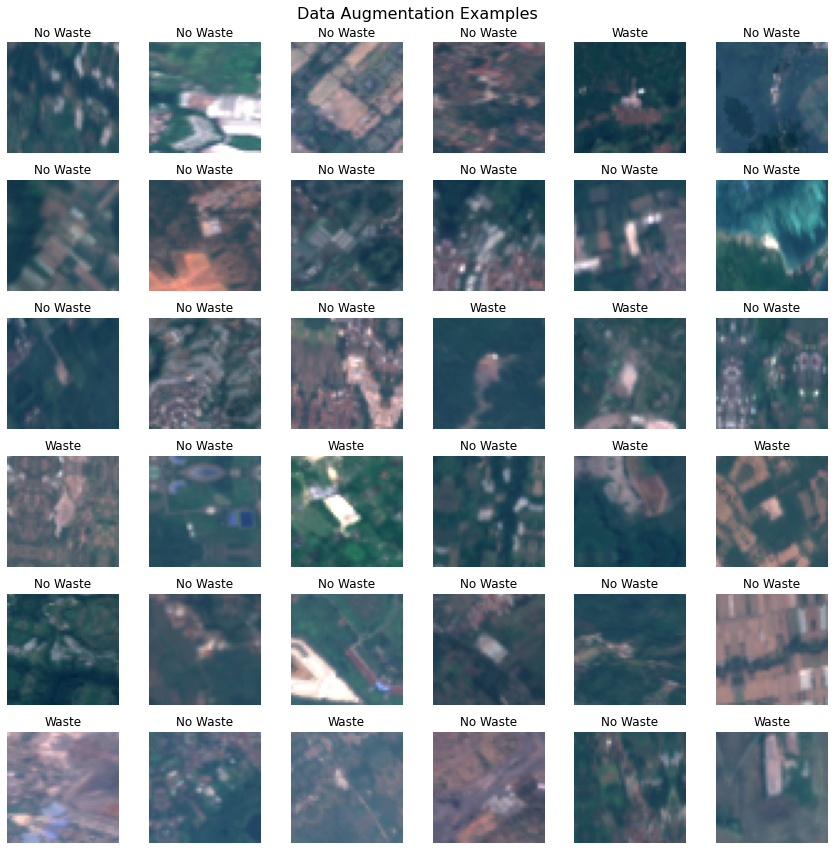

In [323]:
datagen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=[0.8, 1.2],
    height_shift_range=[0.8, 1.2],
    #shear_range=10,
    zoom_range=[0.8, 1.5],
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode='reflect'
)


plt.figure(figsize=(12,12), facecolor=(1,1,1))
images, labels = datagen.flow(x_train, y_train, batch_size=36).next()
for index, (image, label) in enumerate(zip(images, labels)):

    rgb = np.stack((image[:,:,3],
                    image[:,:,2], 
                    image[:,:,1]), axis=-1)
    rgb_stretch = stretch_histogram(rgb, max_val = .8)
    plt.subplot(6,6,index+1)
    plt.imshow(np.clip(rgb_stretch, 0, 1))
    if label[1] == 1:
        plt.title('Waste')
    else:
        plt.title('No Waste')
    plt.axis('off')
plt.suptitle('Data Augmentation Examples', size=16)
plt.tight_layout()
plt.show()
    

## Train Network

In [283]:
input_shape = np.shape(x_train[0])
print("Input Shape:", input_shape)

Input Shape: (45, 45, 12)


In [313]:
model = keras.Sequential([
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2)),
        layers.Conv2D(32, kernel_size=(3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2)),
        layers.Conv2D(64, kernel_size=(3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2)),
        layers.Flatten(),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.1),
        #layers.Dense(32, activation="relu"),
        #layers.Dropout(0.1),
        layers.Dense(num_classes, activation="softmax")])
model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_123 (Conv2D)          (None, 43, 43, 16)        1744      
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 21, 21, 16)        0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 19, 19, 32)        4640      
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 576)             

In [314]:
model.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

In [324]:
batch_size = 16
epochs = 50
model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), 
          epochs=epochs, 
          validation_data = (x_test, y_test),
          verbose = 1
         )

Epoch 1/50
141/141 [==============================] - 6s 43ms/step - loss: 0.3287 - accuracy: 0.8622 - val_loss: 0.3801 - val_accuracy: 0.8247
Epoch 2/50
141/141 [==============================] - 6s 42ms/step - loss: 0.3248 - accuracy: 0.8569 - val_loss: 0.3211 - val_accuracy: 0.8606
Epoch 3/50
141/141 [==============================] - 6s 42ms/step - loss: 0.3264 - accuracy: 0.8578 - val_loss: 0.3327 - val_accuracy: 0.8566
Epoch 4/50
141/141 [==============================] - 6s 43ms/step - loss: 0.3342 - accuracy: 0.8573 - val_loss: 0.3032 - val_accuracy: 0.8685
Epoch 5/50
141/141 [==============================] - 6s 42ms/step - loss: 0.3227 - accuracy: 0.8622 - val_loss: 0.3329 - val_accuracy: 0.8645
Epoch 6/50
141/141 [==============================] - 6s 44ms/step - loss: 0.3183 - accuracy: 0.8680 - val_loss: 0.4253 - val_accuracy: 0.8048
Epoch 7/50
141/141 [==============================] - 6s 43ms/step - loss: 0.3416 - accuracy: 0.8493 - val_loss: 0.3315 - val_accuracy: 0.8327

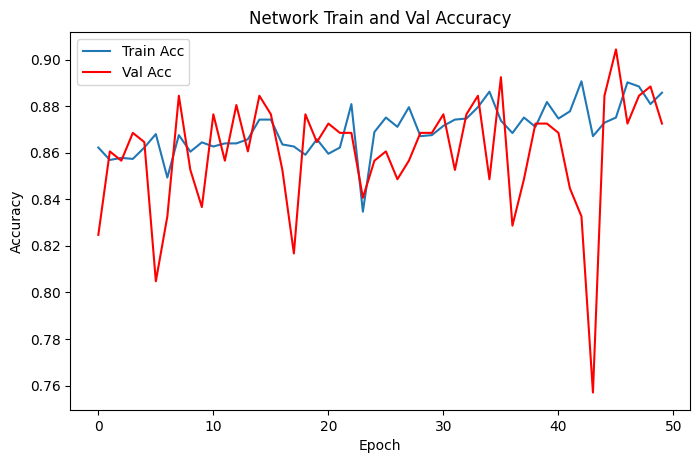

In [325]:
plt.figure(figsize=(8,5), dpi=100, facecolor=(1,1,1))
plt.plot(model.history.history['accuracy'], label='Train Acc')
plt.plot(model.history.history['val_accuracy'], c='r', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Network Train and Val Accuracy')
plt.show()

In [326]:
model.save(f'../models/2020-01-29_patch_classifier_{rect_width}_patch.h5')

## Visualize test predictions

In [327]:
threshold = 0.7

preds_test = model.predict(x_test)[:,1]
positive_img = x_test[preds_test >= threshold]
negative_img = x_test[preds_test < threshold]

print(len(positive_img), "positive samples")
print(len(negative_img), "negative samples")

66 positive samples
185 negative samples


In [319]:
(preds_test >= threshold).astype(int)

array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1])

In [320]:
def plot_samples(sample_stack, title, labels = None):
    num_img = int(np.ceil(np.sqrt(len(sample_stack))))
    indices = np.random.choice(len(sample_stack),len(sample_stack))

    plt.figure(figsize=(12,12), dpi=150)
    for plot_num, index in enumerate(indices):
        plt.subplot(num_img, num_img, plot_num + 1)
        rgb = np.stack((sample_stack[index,:,:,3],
                        sample_stack[index,:,:,2],
                        sample_stack[index,:,:,1]), axis=-1
                      )
        plt.imshow(np.clip(rgb, 0, 1))
        if labels.any():
            plt.title(f"{labels[index]:.2f}")
        plt.axis('off')
    plt.suptitle(title, size=16)
    plt.tight_layout()
    plt.show()

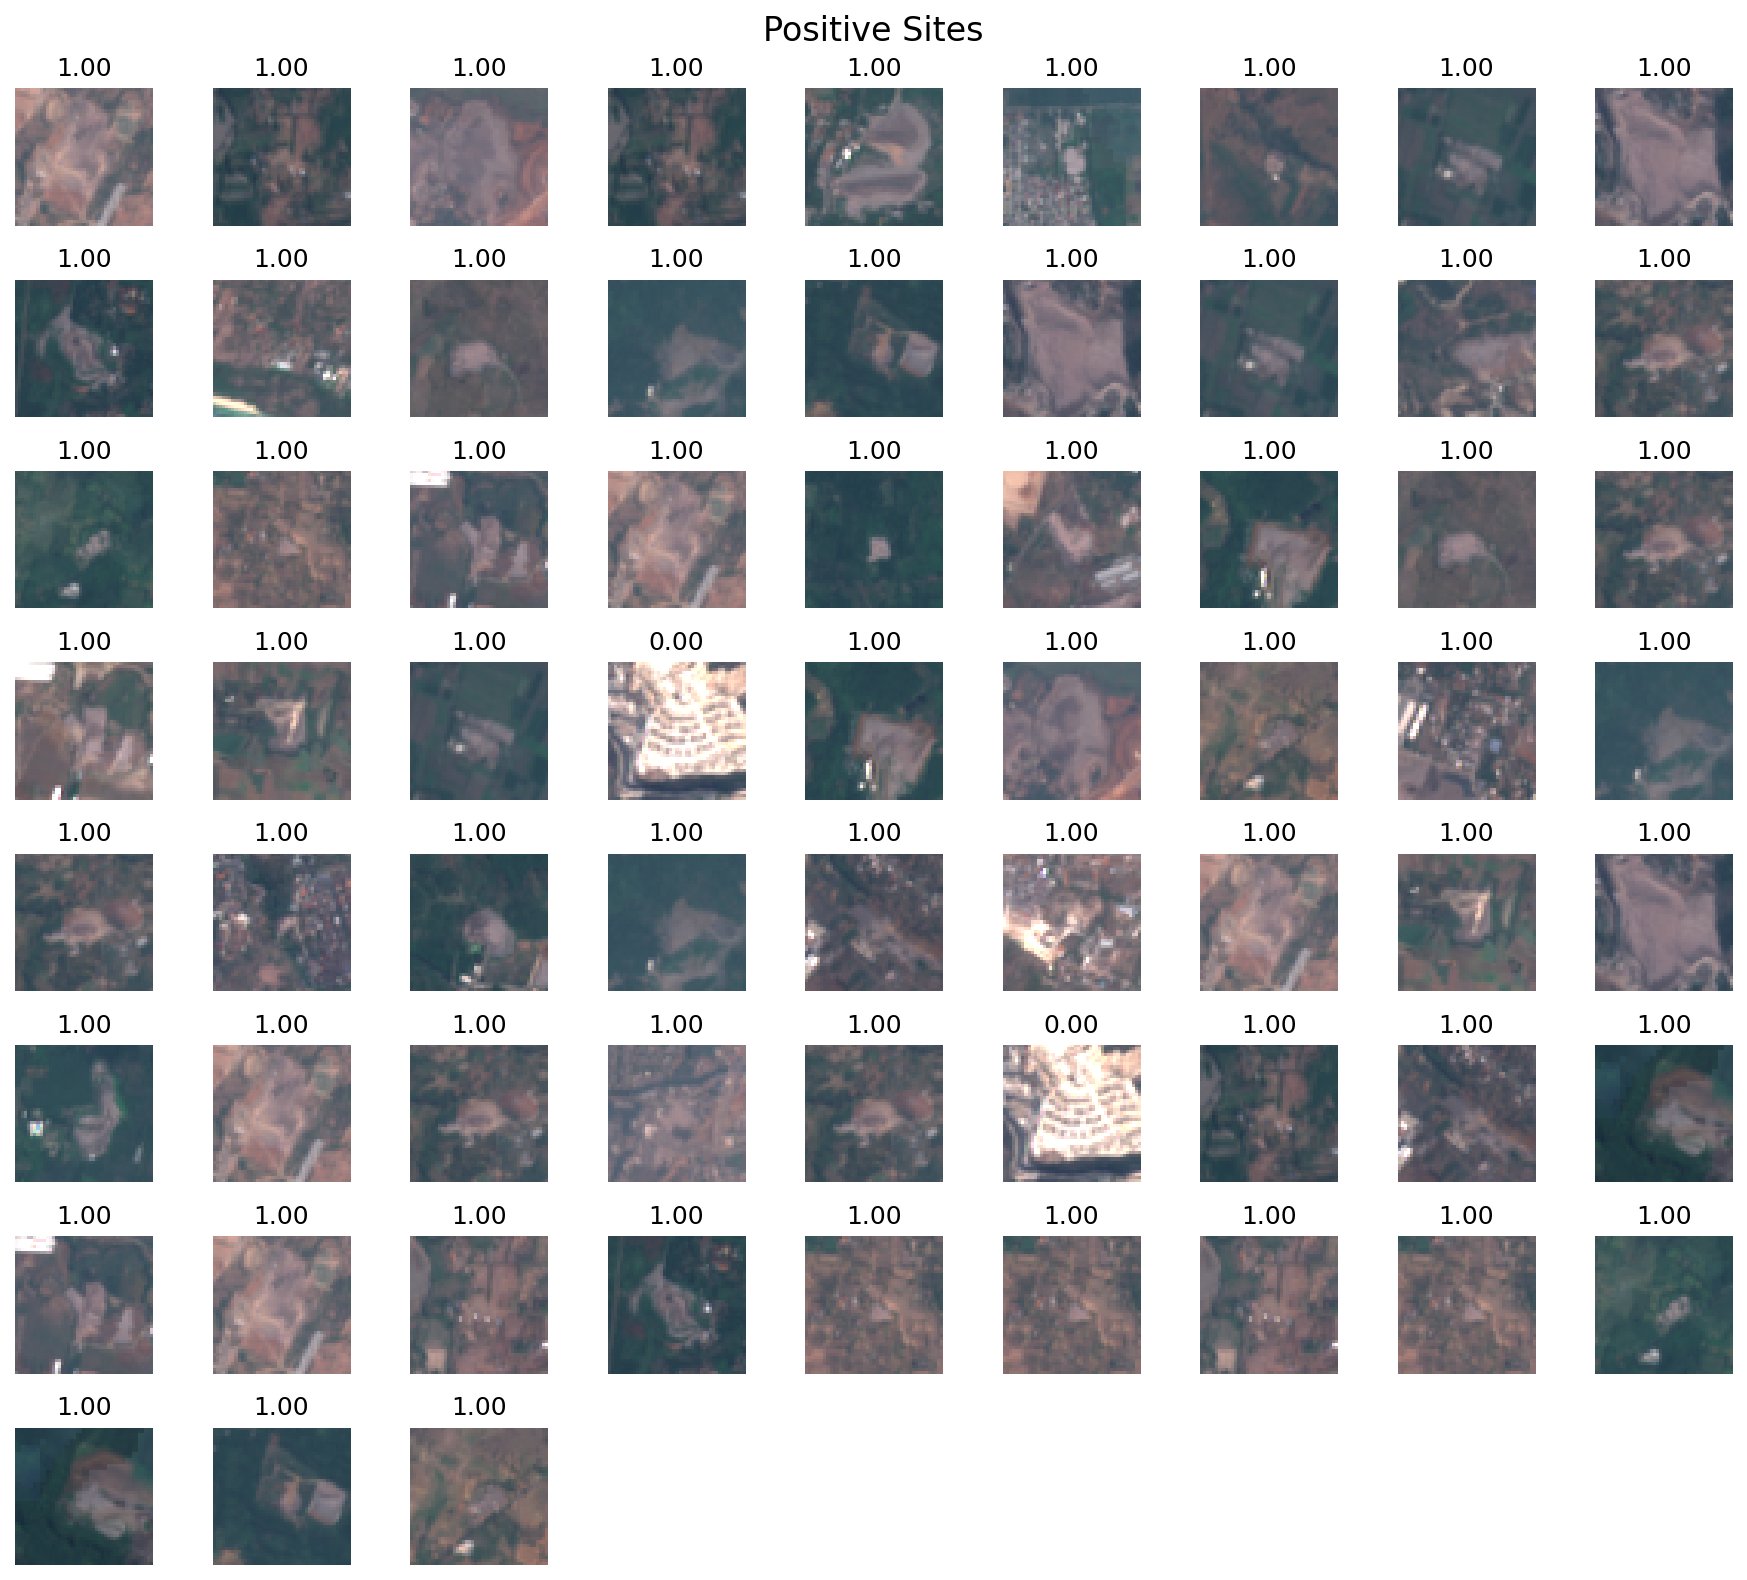

In [328]:
plot_samples(positive_img, 'Positive Sites', np.array(y_test[:,1]).astype(int)[preds_test >= threshold])

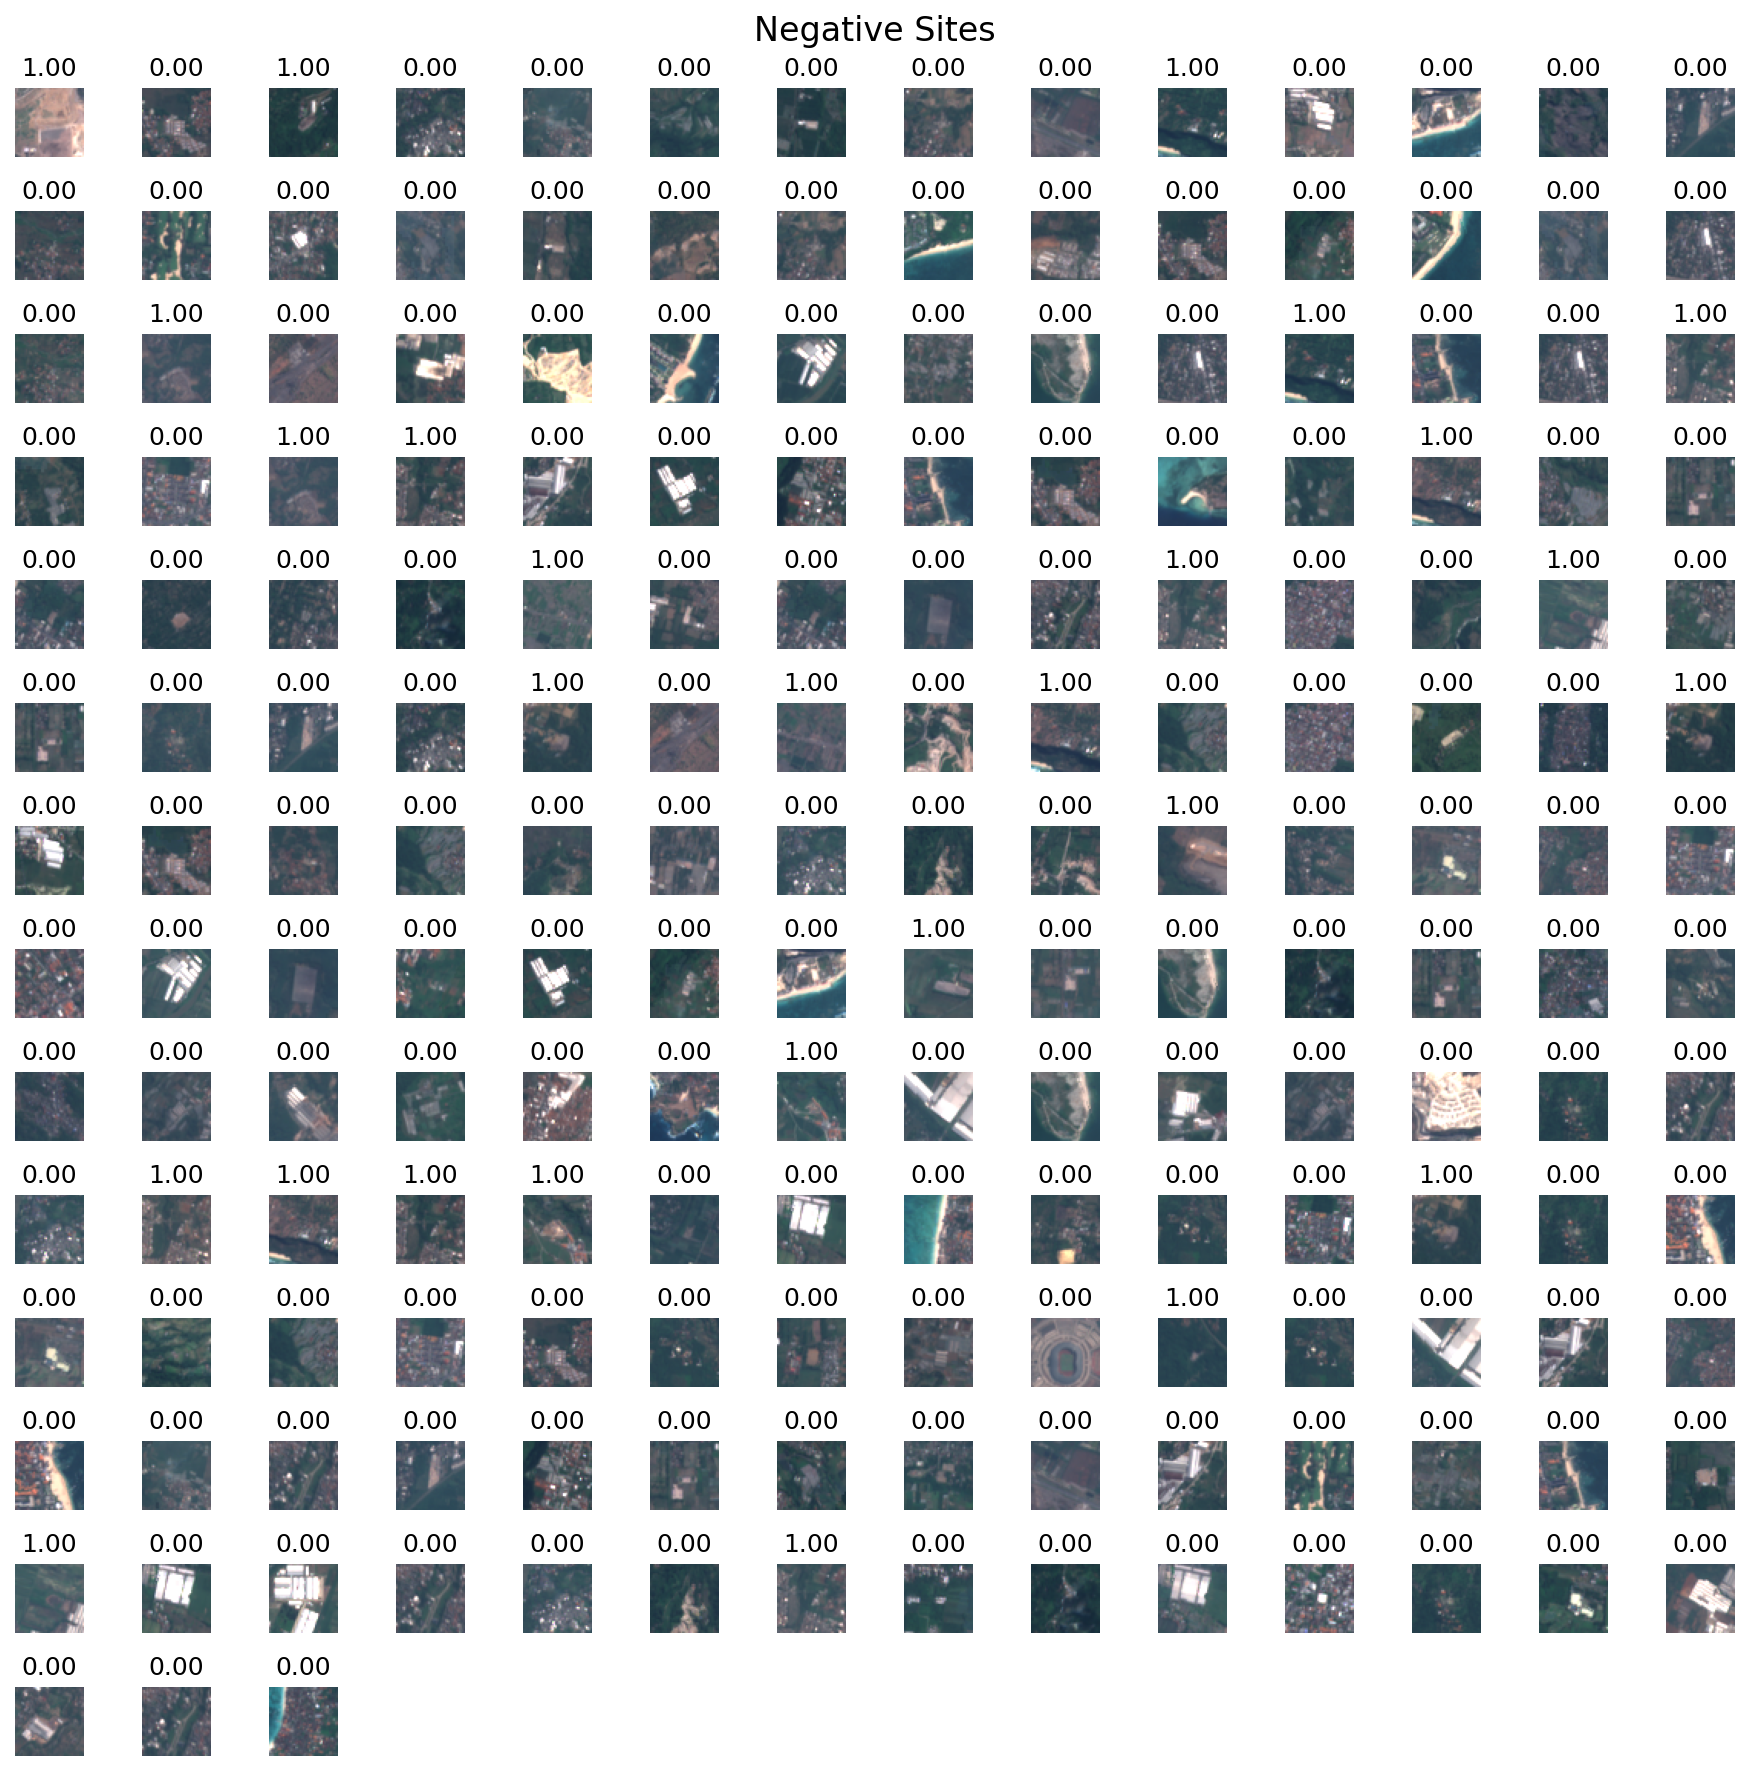

In [329]:
plot_samples(negative_img, 'Negative Sites', np.array(y_test[:,1]).astype(int)[preds_test < threshold])

## Test the network on candidate sites

In [ ]:
def patch_predict(model, coordinates, start_date='2020-06-01'):
    patch_history = get_history(coordinates, 
                                ['test_' + str(i) for i in range(len(coordinates))], 
                                rect_width,
                                num_months = 2,
                                start_date = start_date)
    
    sites = list(patch_history[start_date].keys())
    
    img_stack = normalize(create_img_stack(patch_history))
    img_stack = np.array([img[:84, :84] for img in img_stack])
    preds = model.predict(normalize(img_stack))
    
    plot_samples(img_stack, 'Test Sites', preds[:,1])
    
    return img_stack, preds

In [153]:
['test_' + str(i) for i in range(len([coordinates]))]

['test_0']

In [218]:
preds

array([[0.65352273, 0.34647727],
       [0.65334   , 0.34666005],
       [0.65354663, 0.34645343],
       [0.6534557 , 0.3465443 ],
       [0.65337294, 0.34662703],
       [0.65362525, 0.34637472],
       [0.6535015 , 0.3464985 ],
       [0.65350676, 0.34649324],
       [0.653583  , 0.34641704],
       [0.65348   , 0.34652004],
       [0.6535097 , 0.34649035],
       [0.6533479 , 0.34665212],
       [0.6535205 , 0.34647948],
       [0.65372604, 0.34627396],
       [0.6535224 , 0.34647766],
       [0.65350163, 0.3464984 ]], dtype=float32)

In [ ]:
coordinates = [[115.349941, -8.563113],
               [115.564099, -8.40546],
               [115.454684, -8.529853],
               [114.583677, -8.327249]]
img_stack, preds = patch_predict(model, coordinates)

In [ ]:
test_dataset = detection_summary_v12
dates = list(test_dataset.keys())
sites = list(test_dataset[dates[0]].keys())

threshold = 0.5
all_preds = []
for index, site in enumerate(sites):
    preds = []
    rgb_stack = []
    for date in dates:
        img = []
        band_shapes = [np.shape(test_dataset[date][site][band]) for band in band_descriptions]
        if np.array(band_shapes).all() > 0:
            for band in band_descriptions:
                img.append(normalize(test_dataset[date][site][band]))
            img = np.rollaxis(np.array(img), 0, 3)
            img = img[:84, :84, :]
            if np.min(img) > 0:
                rgb = np.stack((img[:,:,3], img[:,:,2], img[:,:,1]), axis=-1)
                rgb_stack.append(rgb)
                preds.append(model.predict(np.expand_dims(img, 0))[0][1])
    all_preds.append(preds)
    print(site, np.median(preds), candidate_coords[index][1], candidate_coords[index][0])

    if candidate_coords[index] in confirmed_coords:
        print("confirmed")
    plt.imshow(np.clip(np.median(rgb_stack, axis=0), 0, 1))
    plt.axis('off')
    plt.title(f"{np.median(preds):2f}, {len(preds)} {candidate_coords[index] in confirmed_coords}")
    plt.show()

In [166]:
np.shape(img_stack)

(2, 84, 85, 12)

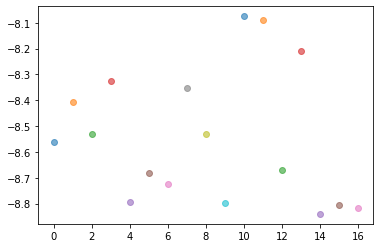

('Connection aborted.', OSError(65, 'No route to host'))


In [179]:
for index,element in enumerate(coordinates):
    plt.scatter(index, element[1], alpha=0.6)
plt.show()

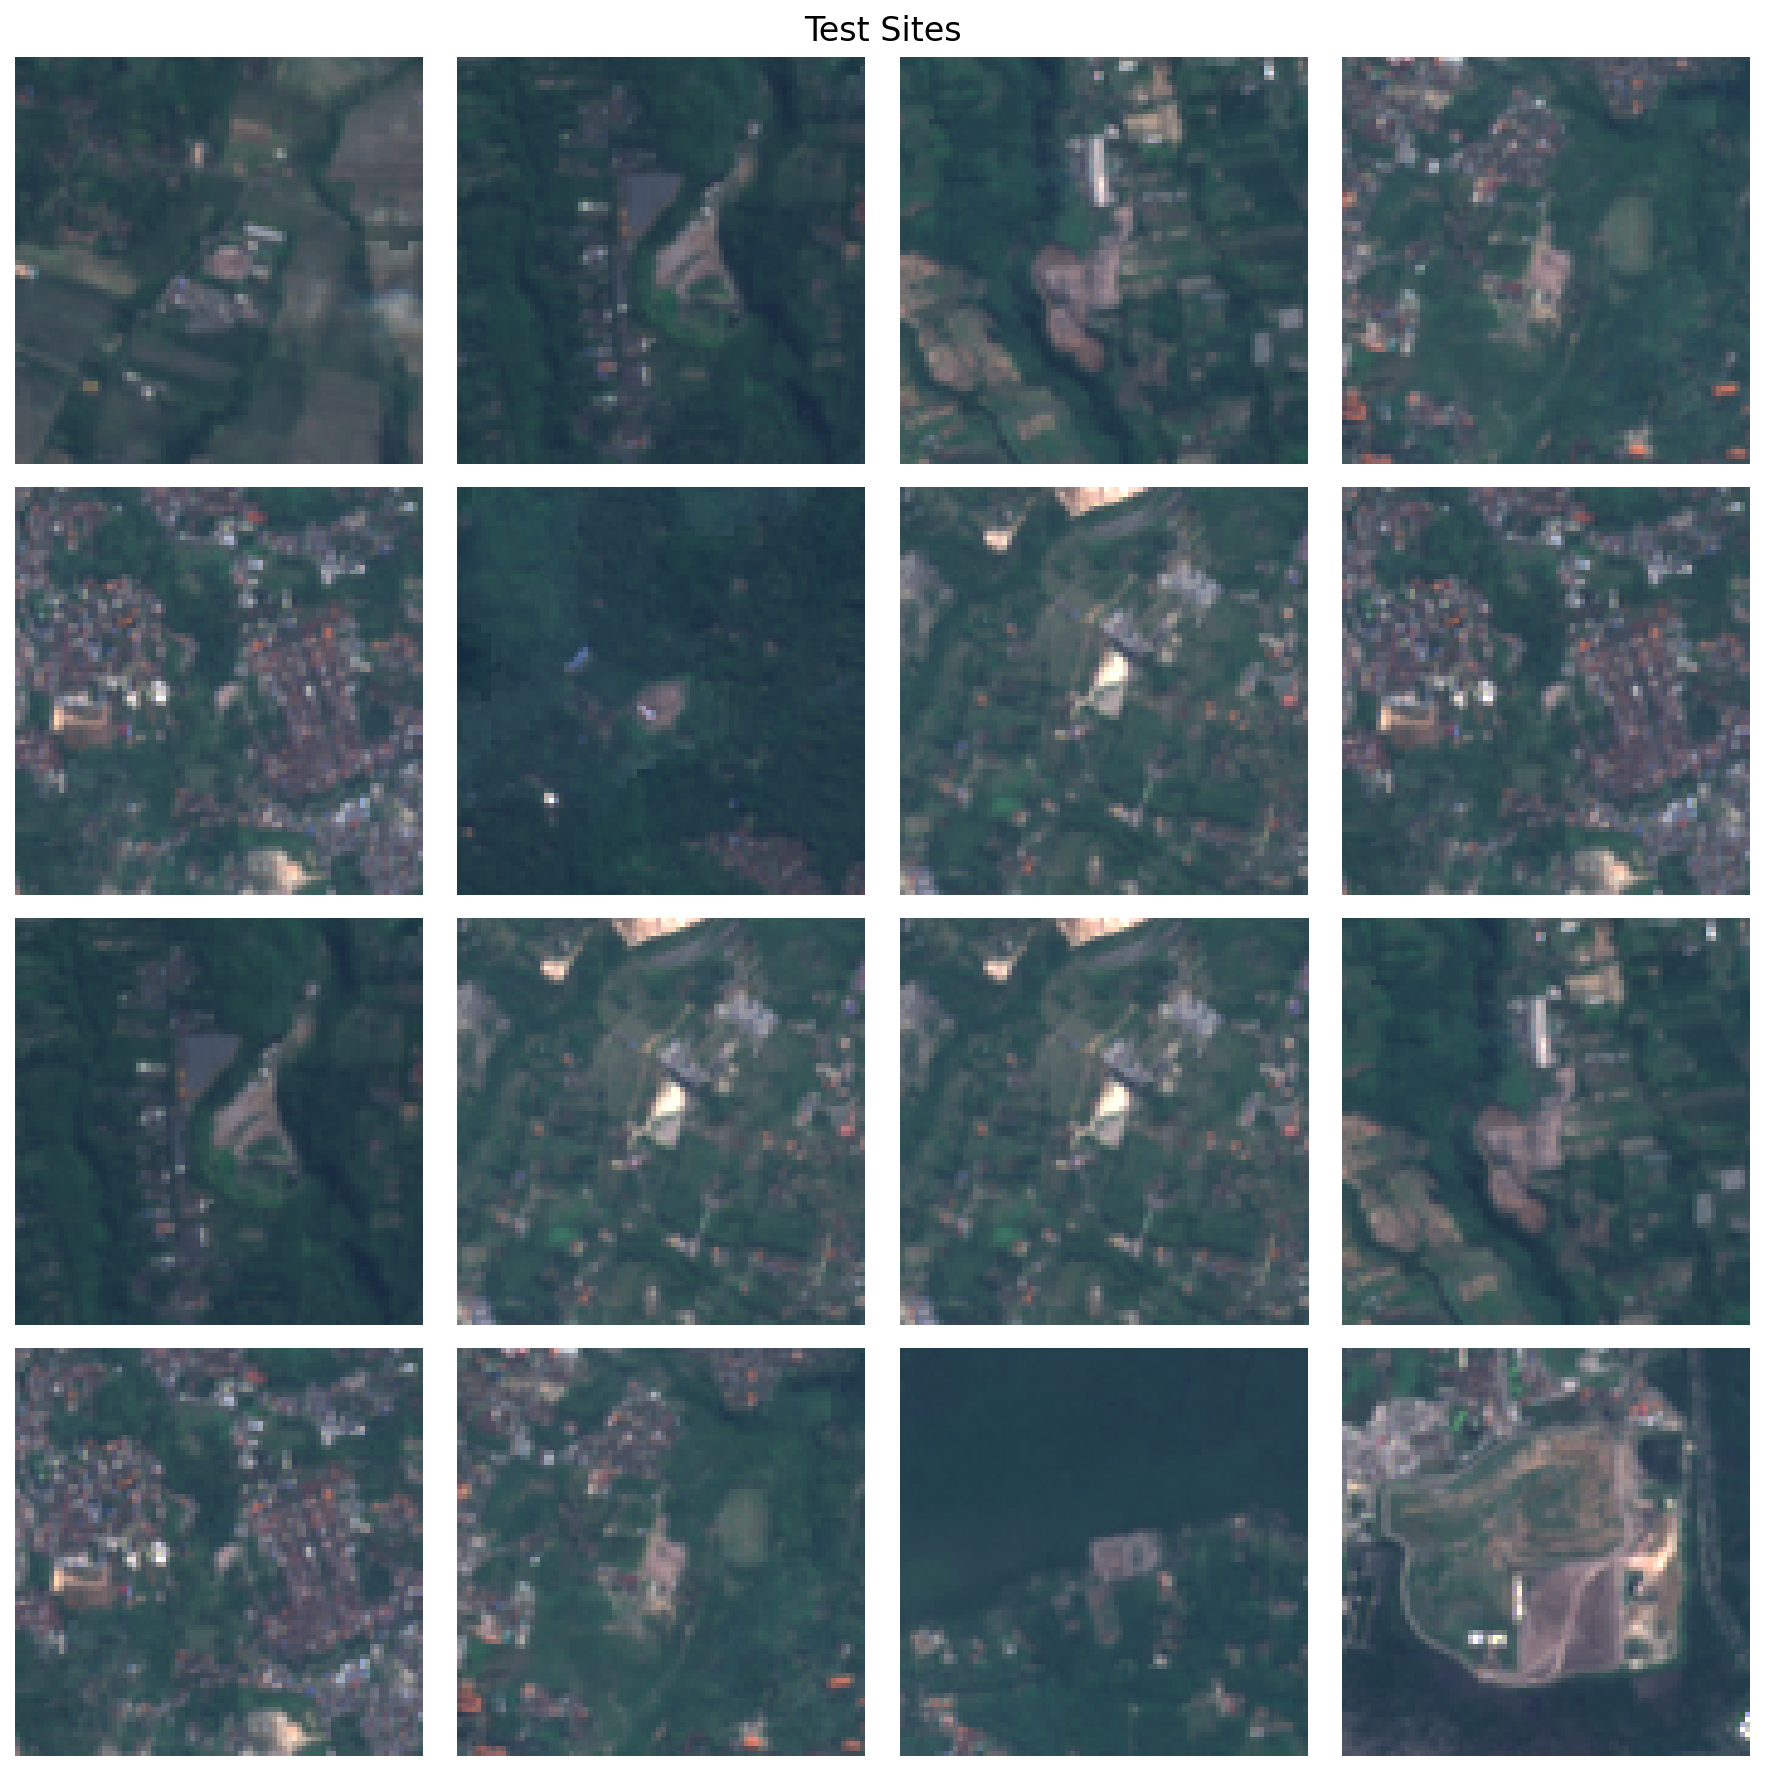

In [176]:
plot_samples(normalize(img_stack), 'Test Sites')

In [ ]:
model.predict(x[:1,:,:])

In [ ]:
# Positive site coordinates

with open('../data/candidate_points_v12.geojson', 'r') as f:
    sites = json.load(f)['features']
candidate_coords = [site['geometry']['coordinates'] for site in sites]
candidate_names = ['candidate_' + str(index) for index in range(len(sites))]
print(len(sites), 'candidate sites loaded')

In [ ]:
detection_summary_v12 = get_history(candidate_coords, 
                           candidate_names, 
                           rect_width,
                           num_months = 6,
                           start_date = '2020-06-01')

In [ ]:
with open('../data/detection_summary_v12.geojson', 'r') as f:
    sites = json.load(f)['features']
confirmed_coords = [site['geometry']['coordinates'] for site in sites]
confirmed_names = [site['properties']['name'] for site in sites]
confirmed_coords

In [ ]:
[coord for coord in candidate_coords if coord in confirmed_coords]

In [ ]:
len(detection_summary_v12['2020-06-01'].keys())

In [ ]:
test_dataset = detection_summary_v12
dates = list(test_dataset.keys())
sites = list(test_dataset[dates[0]].keys())

threshold = 0.5
all_preds = []
for index, site in enumerate(sites):
    preds = []
    rgb_stack = []
    for date in dates:
        img = []
        band_shapes = [np.shape(test_dataset[date][site][band]) for band in band_descriptions]
        if np.array(band_shapes).all() > 0:
            for band in band_descriptions:
                img.append(normalize(test_dataset[date][site][band]))
            img = np.rollaxis(np.array(img), 0, 3)
            img = img[:84, :84, :]
            if np.min(img) > 0:
                rgb = np.stack((img[:,:,3], img[:,:,2], img[:,:,1]), axis=-1)
                rgb_stack.append(rgb)
                preds.append(model.predict(np.expand_dims(img, 0))[0][1])
    all_preds.append(preds)
    print(site, np.median(preds), candidate_coords[index][1], candidate_coords[index][0])

    if candidate_coords[index] in confirmed_coords:
        print("confirmed")
    plt.imshow(np.clip(np.median(rgb_stack, axis=0), 0, 1))
    plt.axis('off')
    plt.title(f"{np.median(preds):2f}, {len(preds)} {candidate_coords[index] in confirmed_coords}")
    plt.show()

In [ ]:
np.shape(rgb_stack)

In [ ]:
test_inputs = create_img_stack(test_dataset)

In [ ]:
for month in test_inputs:
    im = np.expand_dims(normalize(month), 0)
    rgb = np.stack((normalize(month[:,:,3]),
                    normalize(month[:,:,2]), 
                    normalize(month[:,:,1])), axis=-1)
    pred = model.predict(im)[0][1]
    if pred > 0.5:
        plt.imshow(np.clip(rgb, 0, 1), cmap='gray', vmin=0, vmax=1)
        plt.title(f"{pred:.2f}")
        plt.axis('off')
        plt.show()

In [ ]:
median_preds = [np.median(pred) for pred in all_preds]
sum(np.array(median_preds) > 0.8) / len(median_preds)

In [ ]:
test_inputs = [img[:84, :84, :] for img in test_inputs]

In [ ]:
threshold = 0.5
for i in range(len(test_dataset['2020-06-01'].keys())):
    preds = []
    rgb_stack = []
    for month in range(3):
        img = normalize(test_inputs[i + 47 * month])
        im = np.expand_dims(img, 0)
        preds.append(model.predict(im)[0][1])
        rgb = np.stack((img[:,:,3],
                        img[:,:,2],
                        img[:,:,1],), axis=-1)
        rgb_stack.append(rgb)
    if np.median(rgb_stack, axis=0).min() >= 0:
        if np.mean(preds) > threshold:
            plt.imshow(np.clip(np.median(rgb_stack, axis=0), 0, 1))
            plt.title(f"{np.mean(preds):.2f}, {np.std(preds):.2f}\n")
            plt.axis('off')
            plt.show()

In [ ]:
num_months = 6
test_patch = get_history([[80.5821134181353, 5.932532060889194]], 
                           ['sri_lanka'],
                           rect_width,
                           start_date='2020-01-01',
                           num_months=num_months)



In [ ]:
sri_lanka = create_img_stack(test_patch)
sri_lanka = [img[:84, :84, :] for img in sri_lanka]

In [ ]:
for month in sri_lanka:
    im = np.expand_dims(normalize(month), 0)
    rgb = np.stack((normalize(month[:,:,3]),
                    normalize(month[:,:,2]), 
                    normalize(month[:,:,1])), axis=-1)
    pred = model.predict(im)[0][1]
    plt.imshow(np.clip(rgb, 0, 1), cmap='gray', vmin=0, vmax=1)
    plt.title(f"{pred:.2f}")
    plt.axis('off')
    plt.show()